In [1]:
# %load_ext snakeviz
import time
import numpy as np 
import pandas as pd
from ete3 import Tree, TreeStyle

# path = "/home/ivati/Documents/data_TiPS3/"
path = "/home/ivati/montages_reseau/home_maiage/data_v3/"
SIZE = 600

/home/ivati/anaconda3/envs/phylodeep-env/lib/python3.9/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/ivati/anaconda3/envs/phylodeep-env/lib/python3.9/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [3]:
start = time.time()
with open(path+"5Trees.newick",'r') as f:
    forest = f.readlines()
print("Downloading forest took:", time.time()-start, 's')
print(len(forest))

284437


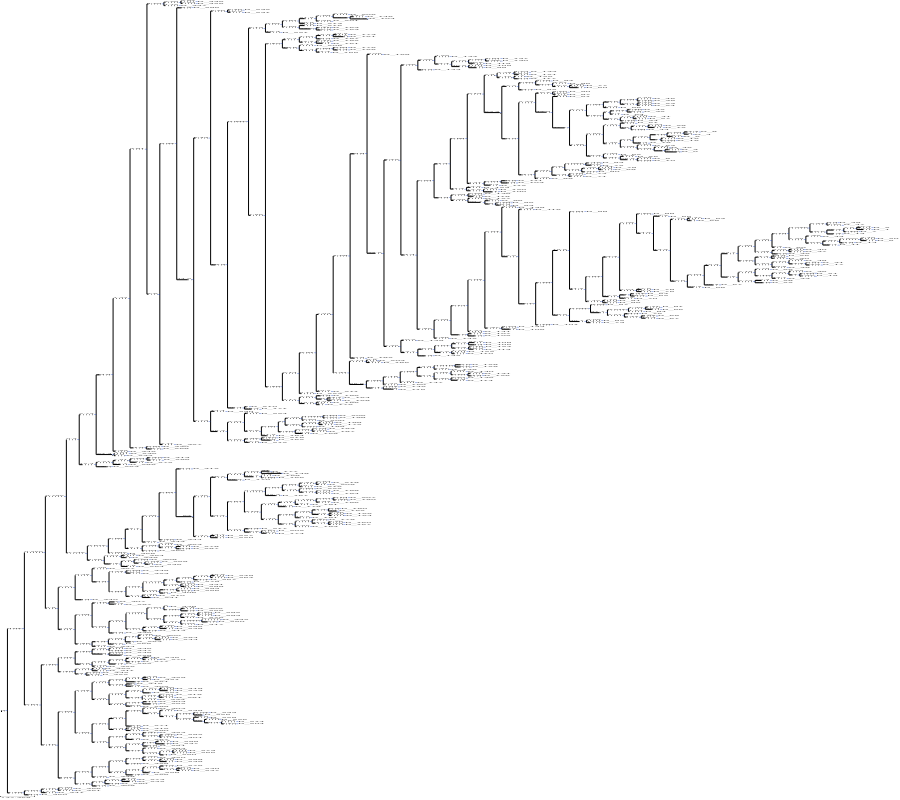

In [73]:
a_tree = Tree(forest[0])
ts = TreeStyle()
ts.show_branch_length = True
a_tree.render(file_name="%%inline", w=900,h=800, tree_style=ts)

In [5]:
print(len(a_tree.get_leaves()))

139


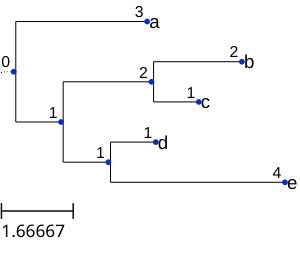

In [6]:
def rescale_tree(tree, target_avg_length=1):
    """
    Returns the rescaling factor and rescale the tree
    :params str_tree: string, newick tree on which we compute the rescaling factor is computed
    :params target_avg_length: float, the average branch length to which we want to rescale the tree
    :returns: float, resc_factor
    """    
    
    branch_lengths = [node.dist for node in tree.traverse()]
    resc_factor = np.mean(branch_lengths)/target_avg_length
    
    for node in tree.traverse():
        node.dist /= resc_factor
    
    return resc_factor


def ladderize(tre):
    """
    Tree ladderization: the branch supporting the most recently sampled subtree is rotated to the left
    :params tre: ete3 Tree, binary tree we want to ladderize
    :return: void, modified the tree tre
    """
    
    # feature to know which subtree is the most recent
    for node in tre.iter_descendants("postorder"):
        if node.is_leaf():
            node.add_feature('subtree_size', node.dist)
        else:
            children = node.children
            node.add_feature('subtree_size', node.dist + max(children[0].subtree_size, children[1].subtree_size))
            
    # swap children so that the most recent is on the left
    for node in tre.traverse():

        children = node.children #if node is leaf children==None
        if children:
            if children[0].subtree_size < children[1].subtree_size:
                node.swap_children()
                
    
            children[0].del_feature("subtree_size")
            children[1].del_feature("subtree_size")
            
            
def inorder_traverse(node, previous_node, vect_lf=[], vect_in=[]):
    """
    Tree traversal (standart recursive algorithm from the depth first family) and encoding
    Inorder tree walk (binary search tree)
    
    Parameters
    -------------------------------
    :param node: current node
    :param previous_node: the most recently visited node
    :param root: 
    :param vect_lf: 1D array that stores the distance between the leaf and the previous_node
    :param vect_in: 1D array that stores the distance between the internal node and the root
    
    Returns
    -------------------------------
    vect_lf, vect_in
    """

    if node.is_root():
        node.add_feature('dist_to_root', 0)
        previous_depth = 0
    else:
        previous_depth = node.up.dist_to_root

    
    if not node.is_leaf(): # node has always 2 children, provided that it is not a leaf
        node.add_feature('dist_to_root', node.dist + previous_depth)
        
        inorder_traverse(node.children[0], previous_node, vect_lf=vect_lf, vect_in=vect_in)
        
        #for internal node, we add its distance to the root
        vect_in.append(node.dist_to_root)
        
        previous_node = node
        inorder_traverse(node.children[1], previous_node, vect_lf=vect_lf, vect_in=vect_in)
        
    else:
        #for tips, we add its distance to the previously visited node
        vect_lf.append(node.dist+previous_depth - previous_node.dist_to_root)

            
    return vect_lf, vect_in


def to_CBLV(tre, maxSize, sampling_p):
    """
    :param tree: ete3 tree, tree that we want to vectorize
    :param maxSize: int, dimension of the vector/NN input
    :return:
    """

    # Tree ladderization
    ladderize(tre)

    # Encoding
    vect_lf, vect_in = inorder_traverse(tre, tre, vect_lf=[], vect_in=[])
    
    # Zero-completion
    tree_vect = np.zeros((2, maxSize))
    tree_vect[0, :len(vect_lf)] = vect_lf
    tree_vect[1, :len(vect_in)] = vect_in
    
    tree_vect[:, -1] = [sampling_p]*2
    
    return tree_vect

# Check algorithm
test_tree = Tree("(a:3,((b:2, c)C:2, (d, e:4)D)B)A;", format=1)
ts = TreeStyle()
ts.show_branch_length = True
test_tree.render(file_name="%%inline", w=300,tree_style=ts)

fact 1.6666666666666667


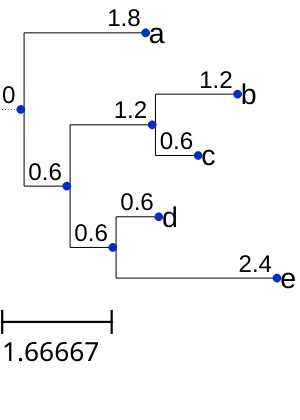

In [7]:
print('fact', rescale_tree(test_tree))
test_tree.render(file_name="%%inline", w=300,tree_style=ts)

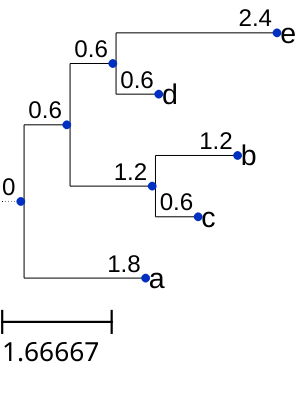

In [8]:
ladderize(test_tree)
test_tree.render(file_name="%%inline", w=300,tree_style=ts)

In [9]:
to_CBLV(test_tree, 8, 0.2).T

array([[3.6, 1.2],
       [0.6, 0.6],
       [2.4, 1.8],
       [0.6, 0. ],
       [1.8, 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0.2, 0.2]])

The corresponding Compact Bijective Ladderized Vector is:
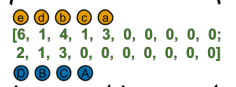

In [64]:
def transform_raw_data(param_file, trees_file, vectors_file, new_params_file, factors_file):
    """
    Rescale time dependent parameters 
    Rescale tree in forest and turn each tree into his CBLV REPRESENTATION
    
    Parameters
    --------------------
    params_file : str, path to the file which stores parameters
    trees_file : str, path to the file which stores newick trees
    vector_file: str, path to the file which stores the CBLV of each tree in trees_file
    new_params_file : str, path to rescaled parameters 
    factors_file : str, path to rescale factor of each tree in trees_file
    """
    
    #Load files
    params = pd.read_table(param_file, sep=" ")
    print('nb params:', len(params))
    
    with open(trees_file,'r') as f:
        forest = f.readlines()
    nb = len(forest)
    print('forest size:', nb)

    params_to_scale = ['mean_signal'] #mean_signal is time dependent
    data_vect = []
    resc_fact = []
    
    
    for i in range(nb):

        tree = Tree(forest[i])
        fact = rescale_tree(tree) # tree is rescaled
        
        resc_fact.append(fact) 
        params.loc[i][params_to_scale] *= fact #some time dependent parameters are scaled

        # stock CBLV representation
        data_vect.append(to_CBLV(tree, SIZE, params.loc[i]['sampling_proba'])) 
            

    # Check shapes
    V = np.array(data_vect)
    F = np.array(resc_fact)
    print(V.shape)
    print(params.shape)
    print(F.shape)
    
    # save features and labels  
    np.save(vectors_file, V)
    params.to_csv(new_params_file, index=False)
    
    # save rescale factors
    np.save(factors_file, F)


st = time.time()
transform_raw_data(param_file=path+"4params.csv", trees_file=path+"4Trees.newick", vectors_file=path+"4CBLV.npy",
                  new_params_file = path+"4scaled_params.csv", factors_file=path+"4factors.npy")
print('Conversion took', (time.time()-st)/60, 'min')
# %snakeviz transform_raw_data()

nb params: 284437
forest size: 284437
(284437, 2, 600)
(284437, 4)
(284437,)
Conversion took 39.03524182637533 min
